   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.1 MB/s eta 0:00:00
Mounting Google Drive...
Mounted at /content/drive
Loading model from: /content/drive/MyDrive/THESIS 47/Saved Models/Final_Model_3Class_RobertaB_OriginalRule_194k
Loading dataset from: /content/drive/MyDrive/THESIS 47/Saved Datasets/Original_Rule_0_4_7_10_194k.csv
--- Data Loading and Splitting (Replicating Part 1 & 2) ---
--- Re-fitting Feature Transformers on Training Data ---
Building test features dictionary...
Feature Dims: Numeric=3, Categorical=50
Tokenizing test dataset...


Map:   0%|          | 0/38883 [00:00<?, ? examples/s]

--- Data Ready for Evaluation ---
Loading trained model and custom weights...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



--- Starting Final Evaluation on Test Set ---


✅ Evaluation Metrics: {'test_loss': 0.6034195423126221, 'test_model_preparation_time': 0.0025, 'test_accuracy': 0.7267186173906335, 'test_f1_weighted': 0.7267057932055704, 'test_precision': 0.7354397399045187, 'test_recall': 0.7267186173906335, 'test_runtime': 459.9657, 'test_samples_per_second': 84.535, 'test_steps_per_second': 5.285}

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Negative     0.5264    0.6419    0.5784      5879
     Neutral     0.7767    0.6545    0.7103     19002
    Positive     0.7673    0.8604    0.8112     14002

    accuracy                         0.7267     38883
   macro avg     0.6901    0.7189    0.7000     38883
weighted avg     0.7354    0.7267    0.7267     38883


--- Generating Confusion Matrix Plots ---


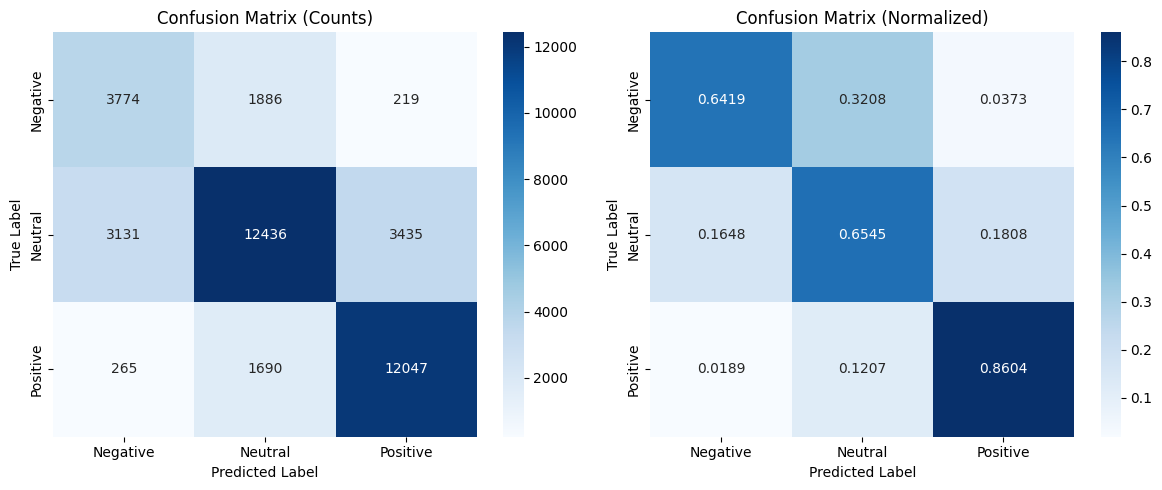


--- Generating Per-Class Metric Bar Chart ---


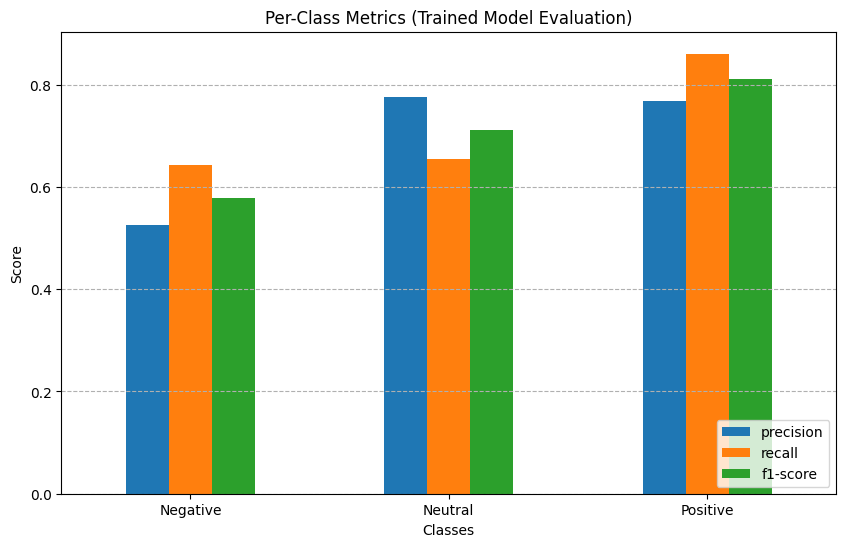


--- Evaluation Complete ---


In [1]:
## 🤖 Colab Code for Evaluation (Loading from Google Drive)
#
# This script loads the saved model and transformer components from your Google Drive,
# re-runs the preprocessing (since the feature transformers are needed), and then
# performs the final evaluation on the test set.

# --- INSTALLING LIBRARIES (Added safetensors) ---
!pip install --upgrade transformers accelerate datasets scikit-learn safetensors -q

# --- CORE IMPORTS (Added safetensors) ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, RobertaModel, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import shutil
import sklearn
from packaging import version
import safetensors.torch # 💥 NEW IMPORT FOR LOADING MODEL

RNG = 42
N_CLASSES = 3
class_names = ['Negative', 'Neutral', 'Positive']
MODEL_CHECKPOINT = "roberta-base"
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
NUM_NUMERICAL_FEATURES = 3

# --- 1. GOOGLE DRIVE MOUNT AND PATHS ---
from google.colab import drive

# 1. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# 2. Define Paths
BASE_DRIVE_PATH = '/content/drive/MyDrive'
DRIVE_MODEL_FOLDER = 'THESIS 47/Saved Models/Final_Model_3Class_RobertaB_OriginalRule_194k'
FINAL_MODEL_PATH = os.path.join(BASE_DRIVE_PATH, DRIVE_MODEL_FOLDER)
FILE_PATH = os.path.join(BASE_DRIVE_PATH, 'THESIS 47/Saved Datasets/Original_Rule_0_4_7_10_194k.csv')

print(f"Loading model from: {FINAL_MODEL_PATH}")
print(f"Loading dataset from: {FILE_PATH}")

# --- 2. MODEL ARCHITECTURE (CRITICAL REDEFINITION) ---
class MultimodalClassifier(nn.Module):
    """
    Multimodal Classifier structure identical to the one used during training.
    """
    def __init__(self, num_labels, num_numerical, num_categorical):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        roberta_hidden_size = self.roberta.config.hidden_size
        self.classifier = nn.Linear(
            roberta_hidden_size + num_numerical + num_categorical,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(roberta_output.last_hidden_state[:, 0])

        combined = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (None, logits)


# --- 3. DATA COLLATOR (CRITICAL REDEFINITION) ---
class MultimodalDataCollator:
    """
    Data Collator to correctly batch all multimodal inputs.
    """
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.stack([f['numerical_features'] for f in features])
        batch['categorical_features'] = torch.stack([f['categorical_features'] for f in features])
        return batch

# --- 4. DATA LOADING AND PREPROCESSING ---
def get_processed_test_data():
    """
    Loads data, splits, and re-fits/applies feature transformers to get the test set.
    """
    print("--- Data Loading and Splitting (Replicating Part 1 & 2) ---")
    df = pd.read_csv(FILE_PATH)
    df = df.dropna(subset=['reviewText', 'target_label']).copy()
    df['label'] = df['target_label'].astype(int)
    df['title'] = df['title'].fillna("")
    df['genre'] = df['genre'].fillna("Unknown")
    df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

    # Stratified Split (MUST be identical to training split)
    train_idx, test_idx = train_test_split(
        df.index, test_size=0.2, random_state=RNG, stratify=df['label']
    )
    train_df = df.loc[train_idx].reset_index(drop=True)
    test_df = df.loc[test_idx].reset_index(drop=True)
    y_train = train_df['label'].values.astype(int)

    # --- FEATURE ENGINEERING (Fit on Train, needed for transform) ---
    print("--- Re-fitting Feature Transformers on Training Data ---")

    # 1. Numeric (Scaler)
    train_numeric = train_df[NUMERIC_COLS].copy()
    train_medians = train_numeric.median(numeric_only=True)
    train_numeric = train_numeric.fillna(train_medians)
    scaler = StandardScaler()
    scaler.fit(train_numeric.values) # Fit on training set

    # 2. Categorical: Genre (MultiLabelBinarizer)
    train_genre_list = train_df['genre'].fillna("Unknown").str.split(', ')
    mlb = MultiLabelBinarizer()
    mlb.fit(train_genre_list) # Fit on training set

    # 3. Categorical: Language (OneHotEncoder)
    train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

    # Handle sklearn version differences
    if version.parse(sklearn.__version__) >= version.parse("1.2"):
        ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
    else:
        ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)

    ohe_lang.fit(train_lang.to_frame()) # Fit on training set

    # 4. Categorical: Director (Target Encoding - Function must be re-defined)
    def director_features_multiclass(train_s, y, test_s, n_splits=5):
        s_train = train_s.fillna("Unknown").astype(str)
        s_test = test_s.fillna("Unknown").astype(str)

        # Frequency (on train)
        freq = s_train.value_counts()
        te_freq = np.log1p(s_test.map(freq).fillna(0).values)[:, None].astype(np.float32)

        # Test set mapping (using full train means)
        n_classes = len(np.unique(y))
        y_ohe = OneHotEncoder(categories=[range(n_classes)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
        global_mean = y_ohe.mean(axis=0)

        full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
        test_df_map = s_test.to_frame(name='did')
        merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
        te_te = merged_test.drop('did', axis=1).values
        mask_test = np.isnan(te_te.sum(axis=1))
        te_te[mask_test] = global_mean

        # Return test features (frequency and target encoding)
        return np.concatenate([te_freq, te_te], axis=1).astype(np.float32)

    # Apply Director Encoding to test set
    test_dir_block = director_features_multiclass(
        train_df['director_encoded'].astype(str), y_train,
        test_df['director_encoded'].astype(str)
    )

    # --- Feature Building for Test Set ---
    def build_test_features(split_df, dir_block, scaler_obj, mlb_obj, ohe_lang_obj, medians):
        out = {}
        out['combined_text'] = split_df['combined_text'].tolist()
        out['label'] = split_df['label'].astype(int).tolist()

        # Numeric (Apply trained scaler and medians)
        numeric = split_df[NUMERIC_COLS].copy().fillna(medians)
        out['numerical_features'] = scaler_obj.transform(numeric.values).astype(np.float32)

        # Genre (Apply trained mlb)
        genre_list = split_df['genre'].fillna("Unknown").str.split(', ')

        # Concatenate all categorical features
        out['categorical_features'] = np.concatenate([
            mlb_obj.transform(genre_list),
            ohe_lang_obj.transform(split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown').to_frame()),
            dir_block
        ], axis=1).astype(np.float32)

        return out

    print("Building test features dictionary...")
    test_feats = build_test_features(test_df, test_dir_block, scaler, mlb, ohe_lang, train_medians)

    # Calculate categorical feature dimension (needed for model init)
    num_categorical_features = test_feats['categorical_features'].shape[1]
    print(f"Feature Dims: Numeric={NUM_NUMERICAL_FEATURES}, Categorical={num_categorical_features}")

    # HF Dataset
    raw_datasets = DatasetDict({
        'test': Dataset.from_dict(test_feats),
    })

    return raw_datasets, num_categorical_features

# 5. EXECUTE DATA PREPARATION
raw_datasets, NUM_CATEGORICAL_FEATURES = get_processed_test_data()

# 6. TOKENIZATION (Must match training's tokenizer)
print(f"Downloading Tokenizer ({MODEL_CHECKPOINT})...")
tokenizer = AutoTokenizer.from_pretrained(FINAL_MODEL_PATH) # Load tokenizer from the saved model folder!

def tokenize_fn(examples):
    # max_length=256 must match training
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing test dataset...")
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")
test_dataset = tokenized_datasets["test"]

print("--- Data Ready for Evaluation ---")

# --- 7. LOAD THE TRAINED MODEL (FIXED FOR SAFETENSORS) ---
# Pass the correct dimensions to the custom model class
print("Loading trained model and custom weights...")
try:
    model = MultimodalClassifier(N_CLASSES, NUM_NUMERICAL_FEATURES, NUM_CATEGORICAL_FEATURES)

    # 💥 FIX: Use safetensors.torch.load_file to load 'model.safetensors'
    WEIGHTS_FILE = "model.safetensors"
    model_weights = safetensors.torch.load_file(os.path.join(FINAL_MODEL_PATH, WEIGHTS_FILE))

    # Load weights into the model
    model.load_state_dict(model_weights)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # Set model to evaluation mode

except Exception as e:
    # This block now catches errors related to model architecture mismatch or file corruption
    print(f"\n❌ CRITICAL ERROR: Could not load the model from {FINAL_MODEL_PATH}")
    print(f"Did you verify the file name is '{WEIGHTS_FILE}' and not 'pytorch_model.bin'?")
    print(f"Error details: {e}")
    raise

# --- 8. DEFINE METRICS FUNCTION (For final report only) ---
def compute_metrics(pred):
    labels = pred.label_ids

    if isinstance(pred.predictions, tuple):
        predictions = pred.predictions[0]
    else:
        predictions = pred.predictions

    preds = predictions.argmax(-1)

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'f1_weighted': f1, 'precision': prec, 'recall': rec}

# --- 9. SETUP DUMMY TRAINER FOR PREDICTION ---
training_args = TrainingArguments(
    output_dir="/tmp/dummy_trainer", # Temporary directory
    per_device_eval_batch_size=16, # Match training batch size for consistency
    report_to="none",
)

eval_trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=MultimodalDataCollator(tokenizer),
    compute_metrics=compute_metrics,
)

# --- 10. EVALUATION ---
print("\n--- Starting Final Evaluation on Test Set ---")
try:
    # Run prediction to get the logits
    preds_output = eval_trainer.predict(test_dataset)
    metrics = preds_output.metrics
    print(f"✅ Evaluation Metrics: {metrics}")

    # Process predictions
    if isinstance(preds_output.predictions, tuple):
        logits = preds_output.predictions[0]
    else:
        logits = preds_output.predictions

    pred_labels = np.argmax(logits, axis=-1)
    true_labels = np.array(test_dataset["label"])

    # 1. CLASSIFICATION REPORT
    print("\n--- Classification Report (Test Set) ---")
    report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True, digits=4)
    print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

    # 2. CONFUSION MATRIX
    print("\n--- Generating Confusion Matrix Plots ---")
    cm = confusion_matrix(true_labels, pred_labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 5))

    # Counts (Integers)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Counts)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Normalized (Floats with 4 decimals)
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Normalized)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

    # 3. PER-CLASS BAR CHART
    print("\n--- Generating Per-Class Metric Bar Chart ---")
    report_df = pd.DataFrame(report_dict).transpose()
    report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
    ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
    plt.title('Per-Class Metrics (Trained Model Evaluation)')
    plt.xlabel('Classes'); plt.ylabel('Score')
    plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend(loc='lower right')
    plt.show()

    print("\n--- Evaluation Complete ---")

except Exception as e:
    print(f"\n❌ A runtime error occurred during evaluation: {e}")
    print("Check the error message above for details (e.g., shape mismatch, incorrect path).")